<div class="alert alert-block alert-info">
    <b>この章の目的</b>
    <p>逆運動学を使ったHSRのアームの駆動方法を学習します</p>
</div> 

# セットアップ作業

逆運動学の計算とアームの駆動にはmoveit_commanderを使います。

ROSの通信を初期化するとともに、moveit_commanderをインポートします。

In [1]:
import rospy
import moveit_commander

rospy.init_node("moveit_command_sender")

moveit_commanderを使って全身を駆動するためのインターフェースを生成するとともに、プランニングが失敗した場合の再プランや、プランニングの計算に含めるワークスペースの座標範囲を設定します。

In [2]:
whole_body = moveit_commander.MoveGroupCommander("whole_body_light")
whole_body.allow_replanning(True)
whole_body.set_workspace([-3.0, -3.0, 3.0, 3.0])

ここでは、moveit_commander.MoveGroupCommanderに引数"whole_body_light"を与えて生成していますが、これは「逆運動学を計算する際に積極的に移動を考慮する」設定です。移動は自律移動機能を使って逆運動学計算時にはあまり移動したくない場合は"whole_body_weighted"を与えて生成してください。

設定済みのエンドエフェクタの名前を確認します。アームの先にあるハンドのリンクが設定されているはずです。

In [3]:
whole_body.get_end_effector_link()

'hand_palm_link'

# 順運動学の計算

ロボットの各関節の角度は、現在、以下の値になっています。

In [4]:
whole_body.get_current_joint_values()

[0.0011436196166222656,
 -0.003783188516954217,
 -0.03398266817008865,
 0.04999814879755954,
 -0.0001366677191150245,
 -1.5697135404119043,
 -1.5713034353598276,
 5.922699373073215e-05,
 0.0]

上記の関節角度は、以下の各関節名に対応します。

In [5]:
whole_body.get_joints()

['world_joint',
 'arm_lift_joint',
 'arm_flex_joint',
 'arm_roll_joint',
 'wrist_flex_joint',
 'wrist_roll_joint',
 'wrist_ft_sensor_frame_joint',
 'wrist_ft_sensor_frame_inverse_joint',
 'hand_palm_joint']

ここで、ロボットの構造は既知なので、ロボットの構造に現在の各関節角度を当てはめ、座標変換を繰り返せばロボットの手先座標を計算できます。

ROSでは、「/robot_description」というパラメータにロボットの構造情報がURDF形式で格納されています。

In [36]:
!rosparam get -p /robot_description | sed '1d' > /tmp/robot.urdf

HSRの場合、以下のような内容です。

In [37]:
!cat /tmp/robot.urdf

  <?xml version="1.0" ?>
  <!-- =================================================================================== -->
  <!-- |    This document was autogenerated by xacro from /opt/wrs/share/hsrb_description/robots/hsrb4s.urdf.xacro | -->
  <!-- |    EDITING THIS FILE BY HAND IS NOT RECOMMENDED                                 | -->
  <!-- =================================================================================== -->
  <robot name="hsrb" xmlns:controller="http://playerstage.sourceforge.net/gazebo/xmlschema/#controller" xmlns:interface="http://playerstage.sourceforge.net/gazebo/xmlschema/#interface" xmlns:sensor="http://playerstage.sourceforge.net/gazebo/xmlschema/#sensor" xmlns:xacro="http://ros.org/wiki/xacro">
    <material name="body_main">
      <color rgba="1.0 0.0 0.0 1.0"/>
    </material>
    <material name="body_sub">
      <color rgba="0.33 0.33 0.33 1.0"/>
    </material>
    <material name="wheel">
      <color rgba="0.2 0.2 0.2 1.0"/>
    </material>
    <materia

URDFには、テキスト形式で各関節とリンクの座標が格納されているのですが、見やすいように画像に変換してみます。

In [41]:
!urdf_to_graphiz /tmp/robot.urdf && dot -T png hsrb.gv -o /tmp/robot.png

Created file hsrb.gv
Created file hsrb.pdf


リンクの親子関係と、その相対座標を表示した画像が得られます。大きな画像なので、スクロールして閲覧してください。

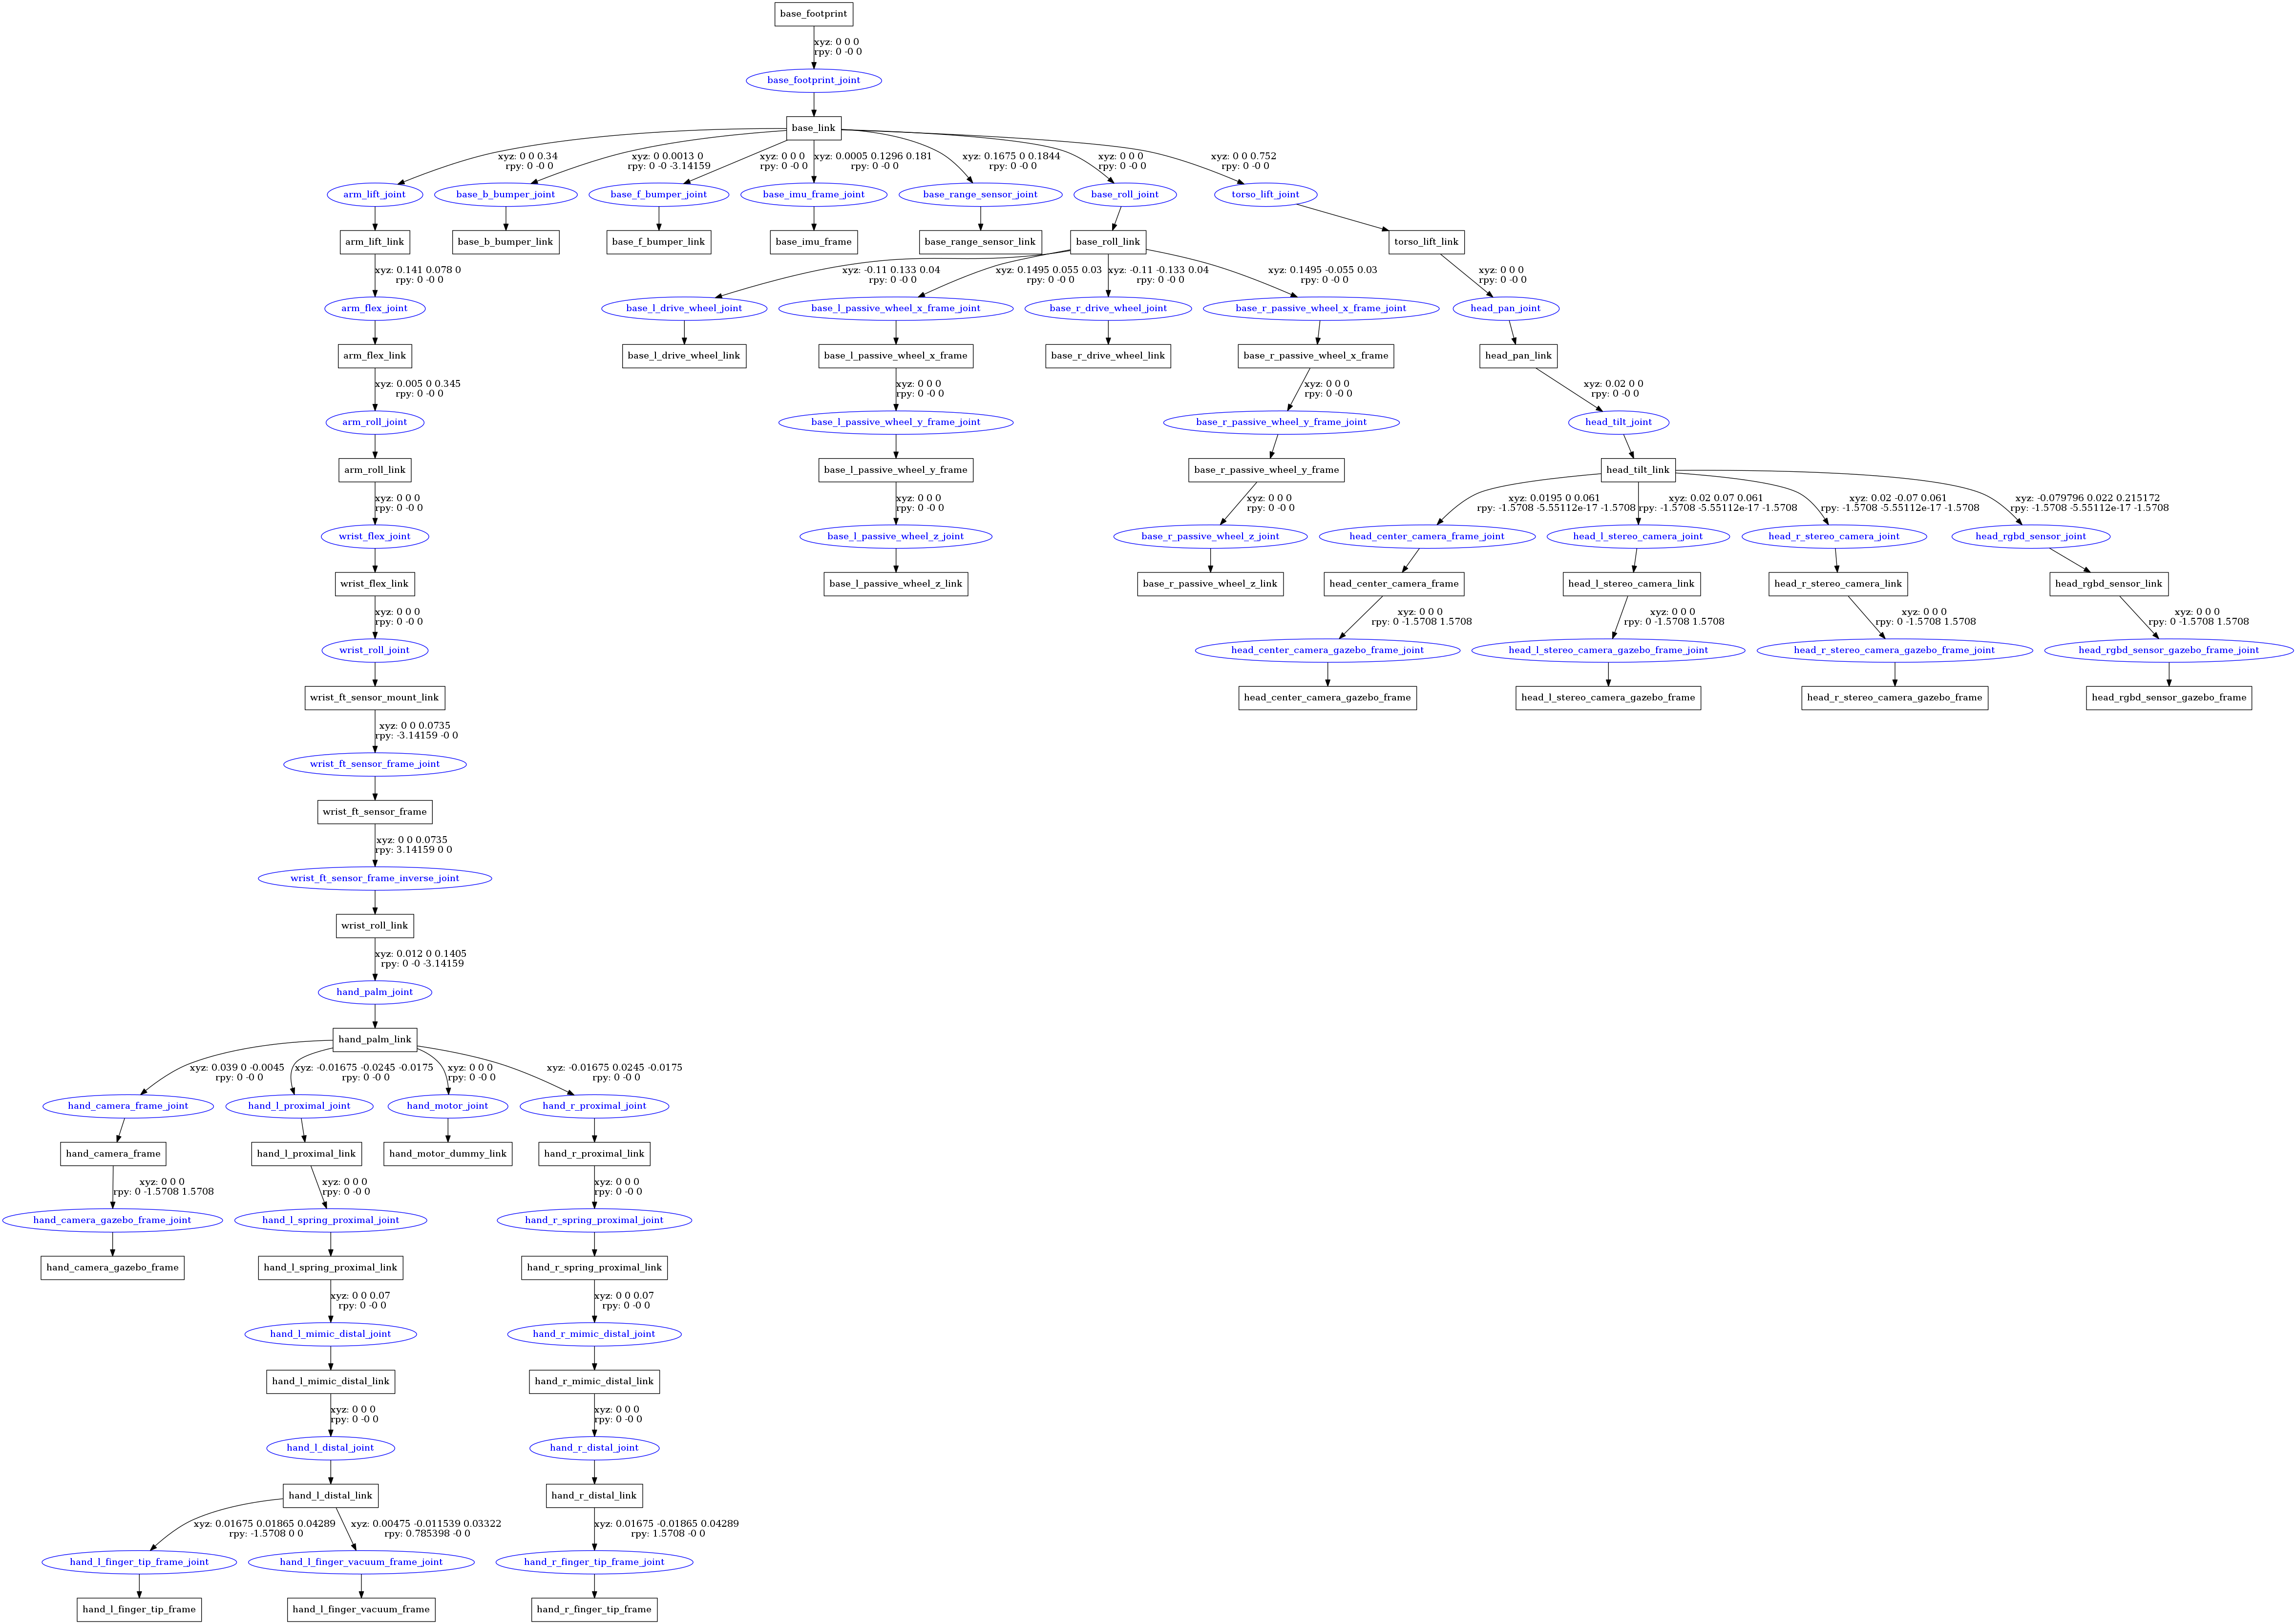

In [43]:
from IPython.display import Image
with open('/tmp/robot.png','rb') as file:
    display(Image(data=file.read(), unconfined=True))

手先座標の計算はmoveitが行ってくれます。我々が行う必要があるのは以下のコマンドを実行するのみです。

関数名が「get_current_pose」となっているので紛らわしいのですが、取得できるのはエンドエフェクタ（手先）部分の位置姿勢です。

In [6]:
pose = whole_body.get_current_pose()
pose

header: 
  seq: 0
  stamp: 
    secs: 383
    nsecs: 807000000
  frame_id: "/odom"
pose: 
  position: 
    x: 0.1451405976
    y: -0.0710795388007
    z: 0.722926764636
  orientation: 
    x: 0.491889540358
    y: -0.508228556378
    z: 0.491636558511
    w: 0.50797825633

手先座標の型は、姿勢を四元数（quoternion）で表現するPoseStamped型です。

In [7]:
type(pose)

geometry_msgs.msg._PoseStamped.PoseStamped

# 逆運動学の計算

目標とする手先座標を与えられた時に、そこからアームの各関節角を逆算することを「逆運動学を解く」と言います。

moveit_commanderを使うと、以下のコマンドで逆運動学を解いてロボットを駆動できます。

まずは、目標の手先座標をPoseStamped型で設定します。

In [8]:
from geometry_msgs.msg import PoseStamped

p = PoseStamped()
p.header.frame_id = "/odom"
p.pose.position.x = 0.2
p.pose.position.y = 0.4
p.pose.position.z = 1.0
p.pose.orientation.x = 0.707
p.pose.orientation.y = 0
p.pose.orientation.z = 0.707
p.pose.orientation.w = 0

whole_body.set_pose_target(p)

ここでは、基準座標（frame_id）として「odom」を使っていますので、目標座標は絶対座標として解釈されます。

HSRの逆運動学は、移動を考慮して計算されます。ここで、上記の目標の基準座標（frame_id）にHSR上のいずれかのリンク名を与えると逆運動学が解けなくなってしまう（目的に近づこうとするとHSRが動くため、HSR座標上で定義された目的も遠ざかってしまう）ので注意してください。frame_idには「odom」か、odomから直接計算される座標を使ってください。

目標を設定後「plan()」コマンドを実行すると、逆運動学の計算が始まります。

計算が成功すると算出された軌跡が返ってきます。逆運動学の解が得られなかった場合（目標の手先座標の設定が適切でなかった場合）は、長さゼロの配列が返ってきますので、目標を修正して再計算してください。

In [9]:
plan = whole_body.plan()
plan

joint_trajectory: 
  header: 
    seq: 0
    stamp: 
      secs: 0
      nsecs:         0
    frame_id: "/odom"
  joint_names: [arm_lift_joint, arm_flex_joint, arm_roll_joint, wrist_flex_joint, wrist_roll_joint,
  wrist_ft_sensor_frame_joint]
  points: 
    - 
      positions: [0.04999745623581288, 1.7968802343837353e-05, -1.5702974925317101, -1.5712976451869416, -4.187383105858089e-05, 0.0]
      velocities: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
      accelerations: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
      effort: []
      time_from_start: 
        secs: 0
        nsecs:         0
    - 
      positions: [0.04999745623581288, 0.0, -1.5702974925317101, -1.5712976451869416, -4.187383105858089e-05, 0.0]
      velocities: [0.017018059380462608, -2.2703030126940353e-05, 0.09862131934020356, 7.498585589355033e-05, -3.088929033040441e-05, 0.0]
      accelerations: [0.0499118297248121, 4.797687394762155e-05, 0.2892439371668682, 0.00021992409283898287, -9.059440708388926e-05, 0.0]
      effort: []
      

「execute()」コマンドを軌跡を引数として与えて実行することで、アームが逆運動学の計算結果に従って動きます。

In [10]:
whole_body.execute(plan)

True

# 関数化

上記の処理を関数化して簡単に呼び出せるようにしましょう。

ここでは、関数内でオイラー角から四元数に変換することで、人間が理解しやすいオイラー角によって手先の方向を設定できるようにしています。

In [11]:
import rospy
import moveit_commander
from geometry_msgs.msg import PoseStamped
import math
from tf import transformations

rospy.init_node("moveit_command_sender")

def move_arm_ik(x, y, z, theta):
    whole_body = moveit_commander.MoveGroupCommander("whole_body_light")
    whole_body.allow_replanning(True)
    whole_body.set_workspace([-3.0, -3.0, 3.0, 3.0])

    p = PoseStamped()
    p.header.frame_id = "/odom"

    p.pose.position.x = x
    p.pose.position.y = y
    p.pose.position.z = z
    
    q = transformations.quaternion_from_euler(-math.pi, 0, theta / 180.0 * math.pi)
    p.pose.orientation.x = q[0]
    p.pose.orientation.y = q[1]
    p.pose.orientation.z = q[2]
    p.pose.orientation.w = q[3]

    whole_body.set_pose_target(p)
    return whole_body.go()

def move_arm_neutral():
    arm = moveit_commander.MoveGroupCommander('arm')
    arm.set_named_target('neutral')
    return arm.go()

def hand(v):
    gripper = moveit_commander.MoveGroupCommander("gripper")
    gripper.set_joint_value_target("hand_motor_joint", v)
    return gripper.go()

# バナナを拾ってみる

上記の関数を使ってバナナを拾ってみましょう。

まずは、バナナをHSRの前方0.4mの位置に出現させます。

In [12]:
!rosrun gazebo_ros spawn_model -database ycb_011_banana -sdf -model banana -x -2.1 -y 0.8

SpawnModel script started
[INFO] [1580364963.433258, 0.000000]: Loading model XML from Gazebo Model Database
[INFO] [1580364963.434191, 0.000000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1580364963.437414, 0.000000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1580364963.728039, 408.434000]: Spawn status: SpawnModel: Successfully spawned entity


ハンドを最大角度まで開きます。

In [13]:
hand(1.0)

True

逆運動学を使ってHSRの手先を前方0.4mの位置に動かします。

In [14]:
move_arm_ik(0.4, 0.0, 0.1, 0)

True

ハンドを閉じます。

In [15]:
hand(0.0)

True

アームを標準姿勢に戻します。

In [16]:
move_arm_neutral()

True

バナナを取るのに失敗した場合、以下のコマンドでバナナを消して、再度出現させると元の取りやすい位置に戻ります。再挑戦してみましょう。

In [17]:
!rosservice call gazebo/delete_model '{model_name: banana}'

success: True
status_message: "DeleteModel: successfully deleted model"
